# Simulating playing card shuffles and calculating their fairness

To determine whether a deck has been shuffled fairly, the resulting order of the cards should not give any edge to anyone who knew the positions of any cards before the shuffle. For example, if a player knows where a particular card is in the deck before a shuffle and tries to guess where it is after the shuffle, their guess should be just as likely to be right as someone else guessing uniformly at random.

The shuffle must have an element of randomness to achieve this. A deterministic shuffle leaves every card in an exactly known position in the deck.

## Shuffle types

First, define a few common types of shuffle.

### Riffle
Take the deck approximately in two halves and interleave the cards from each half with varying numbers of cards at each interleaf.

### Box
Cut the deck approximately into four quarters and reverse the order of these quarters. There should be an element of randomness in the number of cards which go into each quarter - some distribution around 13 cards in each part.

### Cut
As with box, cut the deck approximately in two and reverse their orders.

### The standard shuffle in the World Series of Poker
Riffle, riffle, box, riffle, cut.

First, define these shuffles, representing a deck as an array of unique integers.

In [2]:
from math import floor, log
import matplotlib.pyplot as plt
import numpy as np


def riffle(deck):
    dl = len(deck)
    r = np.random.rand(dl)
    r = np.sort(r)
    r = 2*r % 1
    return deck[np.argsort(r)]
    
def box(deck):
    dl = len(deck)
    n1 = np.random.binomial(dl,0.25)
    n2 = np.random.binomial(dl-n1,0.333333)+n1
    n3 = np.random.binomial(dl-n2,0.5)+n2
    return np.concatenate((deck[n3:],deck[n2:n3],deck[n1:n2],deck[:n1]))
   
def cut(deck):
    return np.roll(deck,np.random.binomial(len(deck),0.5))
    
def shuffle(deck):
    return cut(riffle(box(riffle(riffle(deck)))))

def perfectShuffle(deck):
    return deck[np.argsort(np.random.rand(len(deck)))]

Here's a graphical example of each type of shuffle.

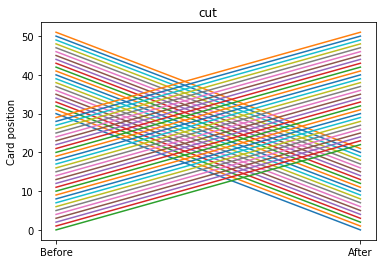

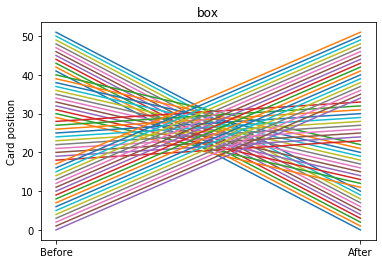

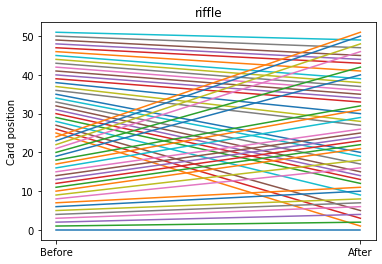

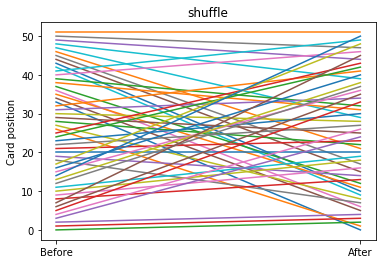

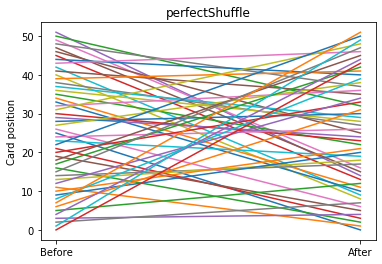

In [45]:
deckSize = int(52)
deck = np.arange(deckSize)

allShuffles = [cut, box, riffle, shuffle, perfectShuffle]

deckShuf = [shuf(deck) for shuf in allShuffles]

# Plot
xLabels = ['Before', 'After']
for (dShuf, shuf) in zip(deckShuf, allShuffles):
    exFig, exAx = plt.subplots()
    for i in deck:
        exAx.plot(xLabels, [dShuf[i], i])
    exAx.set_title(shuf.__name__)
    exAx.set_ylabel('Card position')

A large number of shuffles, $N$, are simulated using the shuffle defined above. For each shuffle, the final position of each card is kept track of in a deckSize $\times$ deckSize array, building up a histogram of final positions of each card.

In [34]:
deckSize = int(52)
deck = np.arange(deckSize)

N = 30000
Nr = 1/N

#decks = np.zeros([N,deckSize],dtype=int)
distrib = np.zeros([deckSize, deckSize])

for i in range(N):
    if i % floor(N/5) == 0:
        print(i)
    shuffled = shuffle(deck)
    # decks[i] = shuffled
    for j in range(deckSize):
        distrib [shuffled[j]] [j] += Nr

0
6000
12000
18000
24000


Example histograms are shown below for the final position of a card which started at the top of the deck, another card which started in the middle, and one at the bottom.

When trying to guess where the card on the bottom of the deck ended up, guessing that it's somewhere in the bottom half of the deck will be correct more than half the time because it hasn't been shuffled unifomly. The card which started in the middle of the deck is more uniformly distributed.

Probability of the bottom card ending up in the bottom half of the deck: 69.9%
Probability of the middle card ending up in the bottom half of the deck: 49.7%


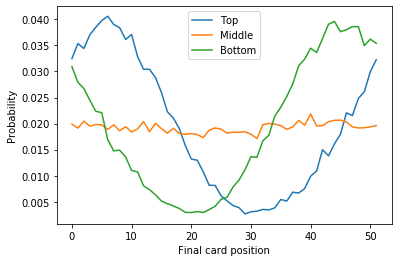

In [35]:
dFig, dAx = plt.subplots();

dAx.plot(distrib[0],label='Top')
dAx.plot(distrib[25],label='Middle')
dAx.plot(distrib[51],label='Bottom')
dAx.set_xlabel("Final card position")
dAx.set_ylabel("Probability")
dAx.legend()

pBottom = sum(distrib[deckSize-1][deckSize//2:])
pMiddle = sum(distrib[deckSize//2][deckSize//2:])

print("Probability of the bottom card ending up in the bottom half of the deck: {:2.1%}"
      .format(pBottom))
print("Probability of the middle card ending up in the bottom half of the deck: {:2.1%}"
      .format(pMiddle))

## Entropy of the shuffle

Now each histogram of final card positions may be treated as a probability distribution. If a card in a particular position in the original deck is shuffled uniformly at random into every possible deck position by the shuffle, its probability distribution will be uniform and so it will have maximal entropy. If it's consistently shuffled into the same position, it will have minimum entropy.

The entropy, $S$, when calculated using logarithm base 2, is measured in bits of information,

$$S = \sum_i -p_i \log_2(p_i)$$

and so the entropy may be interpreted as the number of bits required to determine the card's final position in the deck after shuffling.

In [36]:
entrop = [0 for x in range(deckSize)]
maxEnt = sum([1/deckSize * log(deckSize,2) for i in range(deckSize)])
for i in range(deckSize):
    entrop[i] = sum([(0 if x==0 else -x*log(x,2)) for x in distrib[i]])
    
print("Maximum entropy = {:1.2} bits".format(maxEnt))

Maximum entropy = 5.7 bits


The entropy of the final position distribution for each of the initial card positions is shown below. The cards near the middle of the deck all have nearly the maximum entropy of 5.7 bits and so these cards are being shuffled well. Cards near the top and bottom begin to fall off down to a minimum of 5.3.

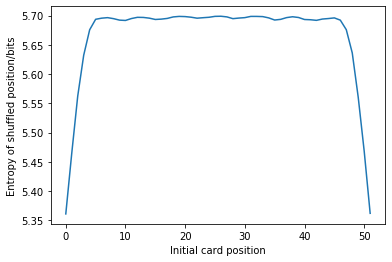

In [37]:
fig1, ax1 = plt.subplots()
ax1.plot(entrop)
ax1.set_xlabel("Initial card position")
ax1.set_ylabel("Entropy of shuffled position/bits")
_=1

## Trying some different shuffles

After defining functions to do the shuffle testing and entropy calculation, any type of shuffle can be tested and their fairness can be compared using this entropy approach.

In [38]:
def repeatShuffle(shuffle, N=10000, deckSize=52):
    deckSize = int(deckSize)
    deck = np.arange(deckSize)

    N = int(N)
    Nr = 1/N

    #decks = np.zeros([N,deckSize],dtype=int)
    distrib = np.zeros([deckSize, deckSize])

    for i in range(N):
        if i % floor(N/2) == 0:
            print("Shuffling decks... {:.2%}".format(i/N))
        shuffled = shuffle(deck)
        # decks[i] = shuffled
        for j in range(deckSize):
            distrib [shuffled[j]] [j] += Nr
            
    return distrib

def entropy(distrib):
    deckSize = len(distrib)
    entrop = [0 for x in range(deckSize)]
    for i in range(deckSize):
        entrop[i] = sum([(0 if x==0 else -x*log(x,2)) for x in distrib[i]])
    return entrop


In [46]:
# Define more shuffles
shuffles = [lambda deck : riffle(riffle(box(riffle(cut(deck))))),
           lambda deck : cut(riffle(box(riffle(riffle(deck))))),
           lambda deck : cut(riffle(riffle(riffle(box(deck)))))]

distribs = ([0 for x in shuffles],)*3

# Simulate many shuffles and calculate the entropy of each one
distribs = [repeatShuffle(shuf) for shuf in shuffles]
ents = [entropy(dist) for dist in distribs]
maxEnts = [log(len(dist),2) for dist in distribs]

Shuffling decks... 0.00%
Shuffling decks... 50.00%
Shuffling decks... 0.00%
Shuffling decks... 50.00%
Shuffling decks... 0.00%
Shuffling decks... 50.00%


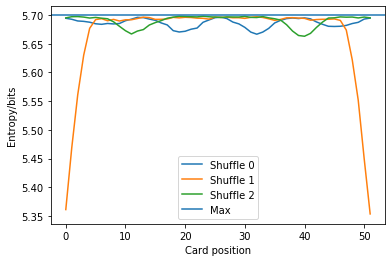

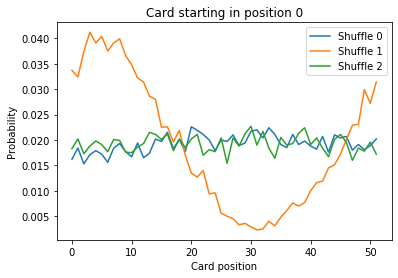

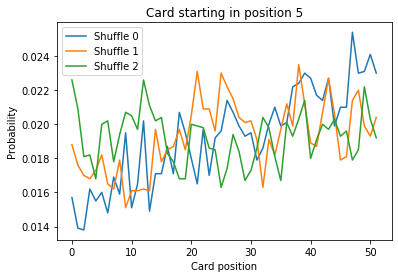

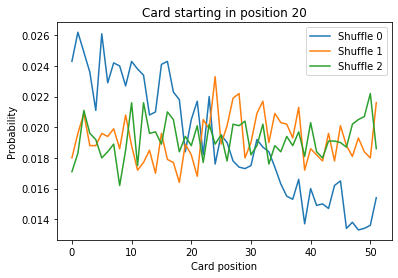

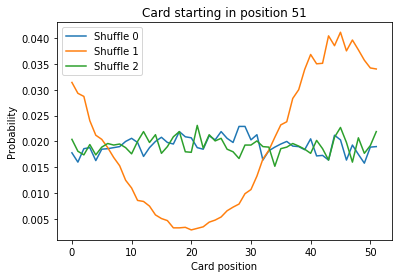

In [47]:
# Plot the entropies of each shuffle
for ii in range(len(ents)):
    plt.plot(ents[ii],label="Shuffle {:1}".format(ii))

if not all(maxEnts[0] == item for item in maxEnts):
    print("Invalid comparison - different max entropies")
plt.axhline(y=maxEnt,xmin=0,xmax=len(distribs[0]), label="Max")
plt.ylabel("Entropy/bits")
plt.xlabel("Card position")
plt.legend()


# Show some example probability distributions from different starting positions
examples = [0, 5, 20, 51]
x = 10

for ii in examples:
    plt.figure()
    for jj in range(len(distribs)):
        plt.plot(distribs[jj][ii],label="Shuffle {:1}".format(jj))
    plt.xlabel("Card position")
    plt.ylabel("Probability")
    plt.title("Card starting in position {:}".format(ii))
    plt.legend()
